# Modeling - Clean

In [1]:
import io
import surprise
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD, SVDpp, BaselineOnly, KNNWithZScore
from surprise.prediction_algorithms import NMF, SlopeOne, NormalPredictor
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

In [12]:
full = pd.read_csv('../Data/filtered-cleaned-git')
full = full.drop(columns = 'Unnamed: 0')

In [13]:
full

,movieId,title,userId,rating
0,100108,Parker (2013),87511,2.0
1,3535,American Psycho (2000),27999,4.0
2,60072,Wanted (2008),50916,3.0
3,60072,Wanted (2008),38845,2.0
4,143355,Wonder Woman (2017),57834,3.0
...,...,...,...,...
4999995,4993,"Lord of the Rings: The Fellowship of the Ring,...",43554,4.0
4999996,47491,Adam's Apples (Adams æbler) (2005),58800,4.0
4999997,62434,Zack and Miri Make a Porno (2008),153447,4.0
4999998,48412,"Guardian, The (2006)",8818,5.0


In [14]:
min_cols = full[[ 'userId', 'movieId', 'rating']]

smaller = min_cols.sample(1000000)

# Below two are the original 
# min_cols = min_cols.sample(5000000)
# smaller = min_cols.sample(50000)

In [15]:
reader = Reader()
data = Dataset.load_from_df(min_cols, reader)
datasmall = Dataset.load_from_df(smaller, reader)
kdata = datasmall.build_full_trainset()
trainset, testset = train_test_split(data, test_size = 0.10)

In [27]:
BaselineOnly_results = cross_validate(BaselineOnly(), datasmall, verbose = False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [28]:
nmf_results = cross_validate(NMF(), datasmall)

In [29]:
NormalPredictor_results = cross_validate(NormalPredictor(), datasmall)

In [30]:
SlopeOne_results = cross_validate(SlopeOne(), datasmall)

In [31]:
SVDpp_results = cross_validate(SVDpp(), datasmall)

In [32]:
SVD_results = cross_validate(SVD(), datasmall)

In [33]:
results_list = [SVD_results, SVDpp_results,
                SlopeOne_results,NormalPredictor_results,
                nmf_results, BaselineOnly_results]

In [34]:
def get_metrics(lst_dicts, key1, key2):
    values = []
    for dct in lst_dicts:
        values.append([dct[key1], dct[key2]])
    return pd.DataFrame(values, columns=[key1, key2])

In [35]:
metrics_df = get_metrics(results_list, 'test_mae', 'test_rmse')

In [36]:
result_names = pd.Series(['SVD_results', 'SVDpp_results', 'SlopeOne_results',
                          'NormalPredictor_results', 'nmf_results', 'BaselineOnly_results'])

In [37]:
sum_df = metrics_df.merge(result_names.rename('models'), left_index = True, right_index = True)

In [38]:
sum_df

,test_mae,test_rmse,models
0,"[0.7465921905817695, 0.7528824961097415, 0.745...","[0.9730164730206795, 0.9880286754214536, 0.969...",SVD_results
1,"[0.7373909392332182, 0.7554475795556157, 0.752...","[0.9543781583323266, 0.9795804626651162, 0.971...",SVDpp_results
2,"[0.8524566826792652, 0.8539070664663115, 0.861...","[1.120664198008467, 1.1176448809715185, 1.1296...",SlopeOne_results
3,"[1.1508060939420504, 1.1394259986731656, 1.149...","[1.4444874440084863, 1.440230547956824, 1.4410...",NormalPredictor_results
4,"[0.891594275304658, 0.8831818048926426, 0.8797...","[1.1337025400831005, 1.1270785282990512, 1.122...",nmf_results
5,"[0.738858366993163, 0.7538226778850153, 0.7562...","[0.9596453798290848, 0.9841301901240056, 0.986...",BaselineOnly_results


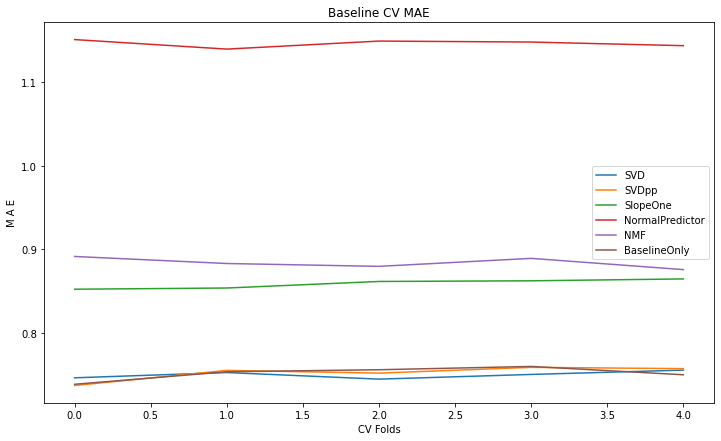

In [39]:
plt.figure(figsize= (12, 7))
plt.plot(sum_df['test_mae'][0])
plt.plot(sum_df['test_mae'][1])
plt.plot(sum_df['test_mae'][2])
plt.plot(sum_df['test_mae'][3])
plt.plot(sum_df['test_mae'][4])
plt.plot(sum_df['test_mae'][5])
plt.title('Baseline CV MAE')
plt.xlabel('CV Folds')
plt.ylabel('M A E')
plt.legend(['SVD', 'SVDpp', 'SlopeOne', 'NormalPredictor', 'NMF', 'BaselineOnly'], loc='best')
plt.show()

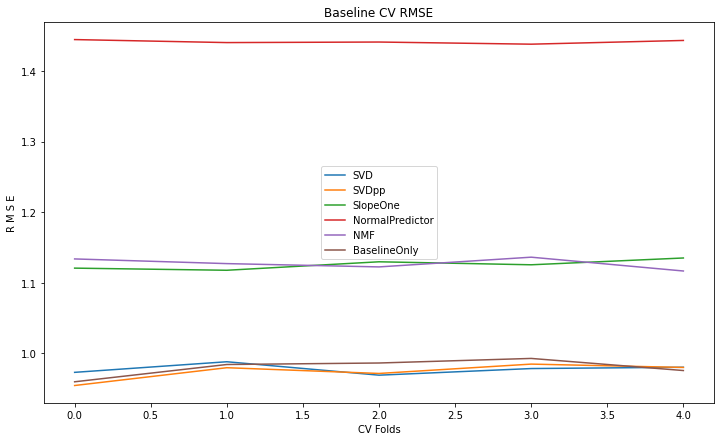

In [40]:
plt.figure(figsize= (12, 7))
plt.plot(sum_df['test_rmse'][0])
plt.plot(sum_df['test_rmse'][1])
plt.plot(sum_df['test_rmse'][2])
plt.plot(sum_df['test_rmse'][3])
plt.plot(sum_df['test_rmse'][4])
plt.plot(sum_df['test_rmse'][5])
plt.title('Baseline CV RMSE')
plt.xlabel('CV Folds')
plt.ylabel('R M S E')

plt.legend(['SVD', 'SVDpp', 'SlopeOne', 'NormalPredictor', 'NMF', 'BaselineOnly'], loc='best')
plt.show()

In [16]:
svd_best = SVD(n_epochs = 50, n_factors = 75, reg_all = 0.2)
svd_best.fit(trainset)

In [17]:
test_mae = surprise.accuracy.mae(svd_best.test(testset))
test_mae

MAE:  0.6443


0.6443098117452206

In [18]:
predictions  = svd_best.test(testset)

In [19]:
test_list = []
for i in testset:
  test_list.append(i[2])
prediction_list = []
for i in predictions:
  prediction_list.append(i[3])
correlation = pearsonr(prediction_list, test_list)
correlation

(0.587679492516447, 0.0)

In [55]:
model_filename = 'Large-rec-model-8M'
pickle.dump(svd_best, open(model_filename, 'wb'))

In [20]:
import lzma
with lzma.open("rec_lmza.xz", "wb") as f:
    pickle.dump(svd_best, f)

In [59]:
import brotli 

with open('Large-rec-model-8M', 'rb') as f:
    pdata = f.read()
    with open('brotli_rec_model.bt', 'wb') as b:
        b.write(brotli.compress(pdata))

In [56]:
# MAE on Test 0.64
# Pearson Correlation 0.59